In [1]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import decord
from decord import cpu, gpu
import numpy as np
import torchvision.transforms as T
import ast
#from lavis.models import load_model_and_preprocess
#import cuda

In [2]:
with torch.cuda.device(torch.device('cuda:4')): 
    info = torch.cuda.mem_get_info()
print(info[0] / info[1])
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device, device2)


0.9926922699652554
cuda:4 cuda:4


In [24]:
import modules

In [14]:
blip = modules.BLIPModel(gpu_number=3)

2023-12-23 12:46:42.275785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 12:46:42.275827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 12:46:42.277025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 12:46:43.496680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
blip.caption()

In [3]:
def get_video(video_path, fps=30):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        print(vlen)
        original_fps = video_reader.get_avg_fps()
        print(original_fps)
        num_frames = int(vlen * fps / original_fps)
        # num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int_)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video

In [4]:
video_id = 3489439407
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')
video.shape

1662
29.97002997002997


torch.Size([1663, 3, 480, 640])

In [5]:
import modules

In [6]:
siglip = modules.SiglipModel(gpu_number=3)

In [7]:
siglip.name

'siglip'

In [8]:
transform = T.ToPILImage()
images = [transform(video[i]) for i in range(0, video.shape[0], 10)]

In [9]:
a = siglip.forward(images, query="Woman in blue with headphones")

TypeError: SiglipModel.forward() got an unexpected keyword argument 'query'

In [13]:
a

[<PIL.Image.Image image mode=RGB size=640x480>]

In [10]:

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

Image features shape:  torch.Size([167, 1152]) Text features shape:  torch.Size([1, 1152])


133/167


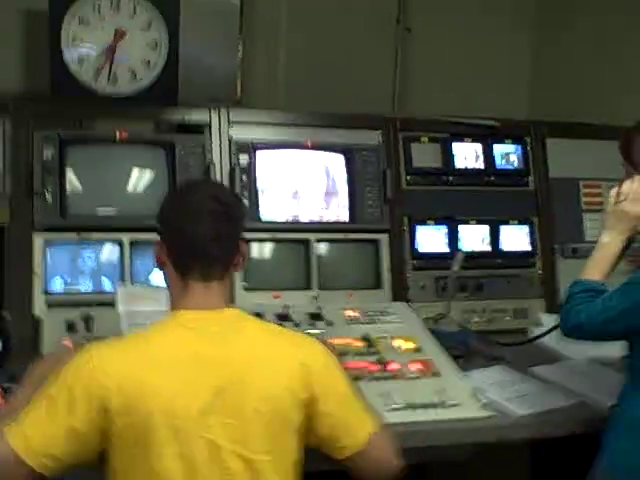

In [24]:
raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{len(images)}")
raw_image

In [46]:
blip.qa(raw_image, "ok")

['in the studio']

In [ ]:
from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
# generate caption
model.generate({"image": image})
# ['a large fountain spewing water into the air']

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
# ask a random question.
question = "What is the man doing in the video?"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
question = txt_processors["eval"](question)
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

In [ ]:
import openai

with open('api.key') as f:
    openai.api_key = f.read().strip()
with open('api_org.key') as f:
    openai.organization = f.read().strip()

def call_llm(prompt):
    completion = openai.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "system", "content": "Follow the directions given in the next prompt carefully."},
        {"role": "user", "content": prompt}
      ]
    )
    output_message = completion.choices[0].message.content
    return output_message


In [ ]:
def get_answer_helper(question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    with open('./prompts/base_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(answer_choices))
    prompt = prompt.replace('insert_curr_frame', str(curr_frame))
    prompt = prompt.replace('insert_total_frames', str(total_frames))
    prompt = prompt.replace('insert_caption', caption[0])

    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [ ]:
def final_select(question, choices, info):
    with open('./prompts/final_prompt.txt') as f:
        prompt = f.read()
    prompt = prompt.replace('insert_question', question)
    prompt = prompt.replace('insert_choices', str(choices))
    prompt = prompt.replace('insert_info', str(info))
    #print(prompt)
    output = call_llm(prompt)
    try:
        output_dict = ast.literal_eval(output)
        print("GETTING OUTPUT: ", output_dict)
        return output_dict
    except:
        print("ERROR: ", output)

In [ ]:
def query_VQA(vqa_question, frame):
    print("CALLING VQA: ", vqa_question)
    model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
    # ask a random question.
    question = vqa_question
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    question = txt_processors["eval"](question)
    answer = model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")
    print("VQA ANSWER: ", answer)
    return answer

In [ ]:
def query_caption(frame):
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](frame).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    return caption

In [ ]:
def get_answer(images, question, answer_choices, curr_frame, total_frames, caption, prev_info=None):
    LIMIT = 10
    goto_frame = curr_frame
    VQA_question = None
    info = {}
    caption = caption
    while LIMIT >= 0:
        print(f"CALL {10 - LIMIT}")
        print("ALL INFO:", info)
        if f"Frame {goto_frame}" not in info:
            info[f"Frame {goto_frame}"] = {}
        LIMIT -= 1  
        if goto_frame != None:
            raw_image = images[goto_frame] 
        caption = query_caption(raw_image)
        print(caption)
        output = get_answer_helper(question, answer_choices, goto_frame, total_frames, caption, prev_info)
        print(output)
        if output["Answer"] != None:
            print("here1")
            return output["Answer"]
        else:
            info[f"Frame {goto_frame}"]["caption"] = caption
            if output["Choose Frame"] != None:
                goto_frame = output["Choose Frame"]
            if output["VQA Question"] != None:
                VQA_question = output["VQA Question"]
                vqa_result = query_VQA(VQA_question, raw_image)
                info[f"Frame {curr_frame}"][VQA_question] = vqa_result
            else:
                continue       
    # case for when we run out of tries
    final_output = final_select(question, answer_choices, info)
    return final_output

In [ ]:
def answer_question(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    return result

In [ ]:
def answer_question_half(vid_id, quest, option_choices, query):
    video_id = vid_id
    question = quest
    options = option_choices
    video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

    model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
    model = model.to(device)
    preprocess = preprocess
    tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

    transform = T.ToPILImage()
    sampling_rate = 10
    images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

    labels_list = query
    image_stack = torch.stack([preprocess(image) for image in images]).to(device)
    text = tokenizer(labels_list, context_length=model.context_length).to(device)


    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_stack)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)
        #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

        text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

    values, indices = torch.topk(text_probs, 3)

    raw_image = images[indices[0][0].item()]
    print(f"{indices[0][0].item()}/{len(images)}")

    from lavis.models import load_model_and_preprocess
    model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
    caption = model.generate({"image": image})
    print(caption)
    raw_image.show()
    return images, caption
    #result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
    #return result

# Q1

In [12]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["bridge with water", "trail with trees", "skate park with people", "house with trees", "bed room with bed"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

raw_image = images[indices[0][0].item() - 150]


2697
29.97002997002997


In [13]:
indices

tensor([[265, 266, 260],
        [266, 265, 260],
        [223, 153, 151],
        [265, 266, 268],
        [268, 265,  37]], device='cuda:4')

In [14]:
print([idx for idx in range(3)])

[0, 1, 2]


In [18]:
raw_images = []
for i in range(len(options)):
    #raw_images.append([indices[i][idx] for idx in range(3)])
    #indices =[indices[i][idx] for idx in range(3)] 
    raw_images.append([images[num] for num in [indices[i][idx].item() for idx in range(3)]])


In [19]:
indices

tensor([[265, 266, 260],
        [266, 265, 260],
        [223, 153, 151],
        [265, 266, 268],
        [268, 265,  37]], device='cuda:4')

In [16]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["bridge with water", "trail with trees", "skate park with people", "house with trees", "bed room with bed"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    #print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{images.shape[0]}")

from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
caption = model.generate({"image": image})
print(caption)
raw_image

2697
29.97002997002997


KeyboardInterrupt: 

In [ ]:
result = get_answer(images, question, options, indices[0][0].item(), len(images), caption, None)
result

# Q2

In [ ]:
video_id = 4010069381
question = "why does the lady walks away after the conversation with man is over?"
options = ['pick up phone', 'enjoying stroll', 'giving her space to perform', 'help man do something else', 'performance ended']

images, caption = answer_question_half(video_id, question, options, "lady walking away")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q3

In [ ]:
video_id = 5907839036
question = "where is this happening?"
options = ['bridge', 'trail', 'skate park', 'house', 'bed room']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "location of the image")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q4

In [ ]:
video_id = 3489439407
question = "what are the two men doing as the lady in blue stands and listen via her headphone?"
options = ['turns around', 'working on the radio', 'moving the papers', 'walk forward', 'choosing a flower']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "lady in blue standing listening to her headphones")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q4

In [ ]:
video_id = 3814690167
question = "why did the man in glasses bounce up and down at the start of the video?"
options = ['warm up', 'supportive audience', 'clap to the beats', 'to show his passion for dancing', 'begin to sing']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "man in glasses bouncing up and down")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

# Q5

In [ ]:
video_id = 11566980553
question = "how does the woman respond after the boy gives her the present?"
options = ['smile', 'puts present aside and ignore him', 'write something down', 'cry', 'walk back to the man']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

images, caption = answer_question_half(video_id, question, options, "woman recieving present from boy")

In [ ]:
output = get_answer(images, question, options, 3, len(images)-1, caption, None)
output

In [ ]:
final_select(question, options, {'Frame 3': {'caption': ['a young boy standing in a living room holding a nintendo wii controller'], 'What does the man do after the boy gives the present?': ['play wii'], "What is the woman's reaction to the boy's present?": ['happy'], "What is the woman's reaction to the boy's gift?": ['happy'], 'What is the woman doing in the video?': ['eating'], 'What are the kids doing on top of the couch?': ['playing'], 'What is happening in the video?': ['playing wii']}, 'Frame 150': {'caption': ['a young boy sitting on the floor reading a book']}, 'Frame 30': {'caption': ['a couple of kids sitting on top of a couch']}, 'Frame 133': {'caption': ['a young boy sitting on the floor holding a wii remote']}})

In [ ]:
"['smile', 'puts present aside and ignore him', 'write something down', 'cry', 'walk back to the man']",,how does the woman respond after the boy gives her the present?,1,11566980553.mp4

- Image level allows you to go back and forth in time, can't do in video-models
    - Binary search aspect -> start in middle -> move forward if not
    - Exponential or recursive
- Image level leveraging for video -> algorithm efficiency analysis
- Show that it works for multiple datasets
- List of different datasets other than NextQA

In [ ]:
import dataset

In [ ]:
dataset.get_data("queries_2k.csv")

# New Testing

In [8]:
import modules
from dataset import MyDataset

In [9]:
dataset = MyDataset(data_path="/shared/shang/datasets/nextqa/videos/",
                    query_file="/shared/shang/datasets/nextqa/metadata/queries_2k.csv",
                    max_samples=50)

In [10]:
item = dataset[21]

In [11]:
item

{'index': 21,
 'sample_id': 3659,
 'possible_answers': "['playing with man', 'he was stuck at the sofa', 'want to push vacuum cleaner forward', 'for baby to clean floor', 'teaching the kid']",
 'query_type': '',
 'query': 'why is the baby hiding behind the vacuum cleaner in the beginning?',
 'answer': 2,
 'video_name': '3429509208.mp4',
 'video': [<PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Image image mode=RGB size=640x480>,
  <PIL.Image.Im

In [12]:
siglip = modules.SiglipModel(gpu_number=6, siglip_model_type="ViT-B-16-SigLIP")
llava = modules.LLAVA(gpu_number=5)

In [ ]:
llava = modules.LLAVA(gpu_number=5)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
keyframe = siglip.forward(images=item['video'], queries=["baby hiding behind vaccuum cleaner"])

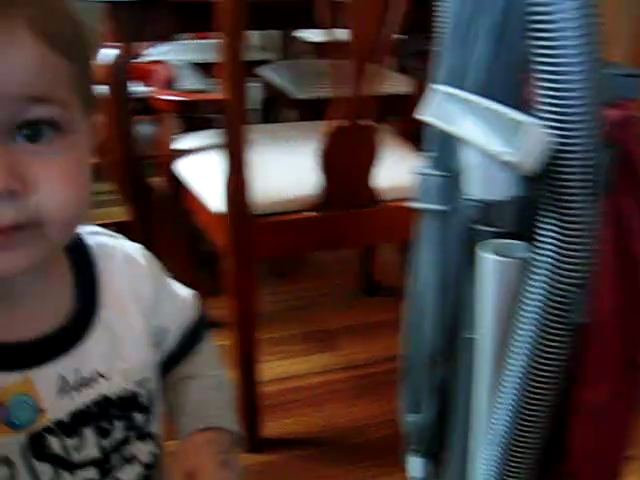

In [20]:
keyframe[1][0][0]

In [21]:
keyframe[0], len(item["video"]), keyframe[0]/ 30, len(item["video"]) /30 

(tensor([[430]], device='cuda:6'),
 467,
 tensor([[14.3333]], device='cuda:6'),
 15.566666666666666)

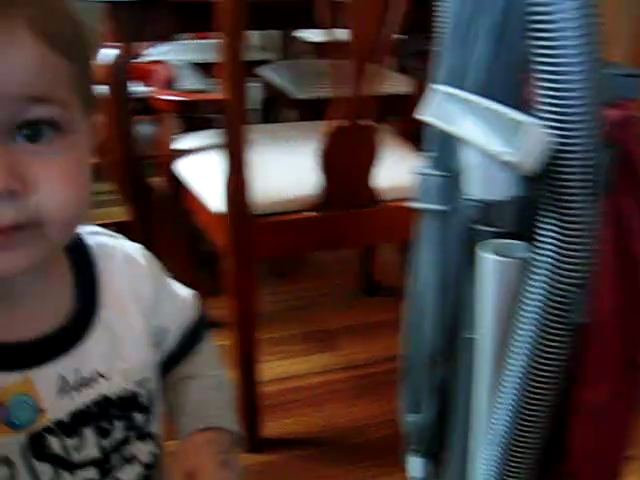

In [72]:
key = keyframe[1][0][0]
key

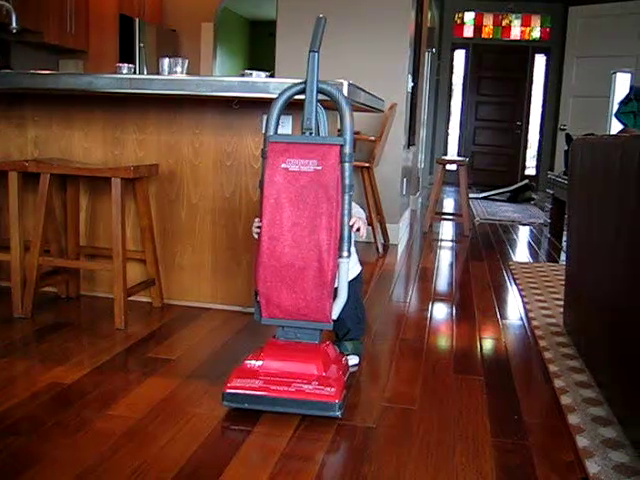

In [74]:
key2 = item["video"][90]
key2

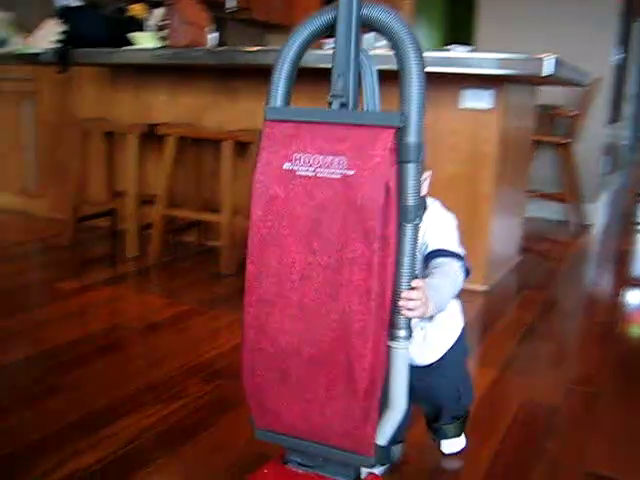

In [80]:
key3 = item["video"][200]
key3

In [73]:
out = llava.forward([key], "Describe the image in as much detail as possible.")
out

'The image features a young child sitting in a high chair, wearing a white shirt. The child appears to be looking at something in front of them, possibly a toy or an object of interest. The high chair is placed in a dining area, with a dining table nearby.\n\nThe room also contains several chairs, with one chair positioned close to the child and two others placed further away. There is a handbag placed on the floor, and a cup can be seen on the dining table. The scene gives off a cozy and comfortable atmosphere, likely in a home setting.'

In [82]:
out = llava.forward([key2], "Is there a baby behind the vaccuum cleaner, and if so, what is the baby doing?")
out

'Yes, there is a baby behind the vacuum cleaner. The baby is playing with the vacuum cleaner, likely enjoying the experience of being close to the machine and possibly imitating the actions of an adult using the vacuum.'

In [85]:
out = llava.forward([key3], "Describe the scene in as much detail as possible, focusing on the vaccum. Include the bounding boxes of objects.")
out

'The image features a young child standing in a kitchen, holding a red vacuum cleaner. The child is positioned near the center of the scene, and the vacuum is held above their head. The kitchen is equipped with a sink, a refrigerator, and a dining table. \n\nThere are two chairs in the kitchen, one on the left side and another on the right side. A bottle can be seen on the countertop, and a bowl is placed on the dining table. A handbag is also visible in the scene, located near the left side of the image.'

In [91]:
out = llava.forward([key2, key3], "Describe the changes across the scene. What happens to the vaccuum cleaner?")
out

"In the image, a young boy is playing with a red vacuum cleaner in a living room. The vacuum cleaner is positioned near the boy, and he appears to be holding it. As the boy moves around the room, the vacuum cleaner follows him, creating a playful and engaging scene. The boy's interaction with the vacuum cleaner adds a sense of fun and curiosity to the image, as he explores the device and its functions."

In [2]:

import modules

In [5]:
llm = modules.GPTModel(gpu_number=5)

In [7]:
llm.forward("Write a sonnet about frogs.", process_name=None)

"In nature's symphony, a chorus swells,\nA lively serenade, a joyful hue,\nThe marshy rhythm of the watery wells,\nResounding croaks, in green and gold, they do.\n\nBehold the frogs, enchanting with their leaps,\nAdorned in vibrant shades of emerald hue,\nTheir eyes, like precious gems, forever peeps,\nReflecting nature's prism, ever true.\n\nThey hop and dance upon the lily pads,\nTheir melodies, a charming serenade,\nA tribute to the shallows, where life glads,\nWhere flickering fireflies lend their aid.\n\nThus, in the frog's melodious refrain,\nA symphony of nature's joy we gain."